In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.widgets import Slider
sb.set_theme("notebook", style="darkgrid" )

%matplotlib widget

![alt text](ex21-a.png)

The definitions used in eq. (77)-(80) are for the right self-energy, so that $V$ corresponds to hopping from left to right, and $V^\dagger$ vice versa.  
If we have a semi-infinite system, with site 0 being the right-most cell, then we calculate the left self-energy using the same equations but with the $V$ and $V^\dagger$ being opposite of before.

The system is simply symmetric, so if we want to reuse the same system of equations, then we just make the correction above.

![alt text](ex21-b.png)

Like the previous system, where the right self-energy we determined from site 0, and then using that the bulk system has both the left and right self-energies, we can find the left.  

Now the system is mirrored, and so we have that the left self-energy is determined from site 0, and using the bulk system, we determine the left and right self-energies, and finally we find the right self-energy.

![alt text](ex21-c.png)

In [12]:
# initialize energy
Energy = np.linspace(-2, 2, num=1001)

# Initilze hooping matrix and on-site matrix
hopping = np.array([[0,0,0,0],
                    [1,0,0,0],
                    [0,0,0,1],
                    [0,0,0,0]])
on_site = np.diag(np.ones(3), -1) + np.diag(np.ones(3), 1)

## Using Broadcasting

In [13]:
## Use broadcasting
def Greens_broadcast(energy, h, h_s, V, eta=1e-4, tol=1e-6, max_iter=30):
    """
    Compute the Green's function for a semi-infinite chain using numpy broadcasting.

    This function calculates the bulk and surface Green's functions for a system with 
    a semi-infinite chain, using iterative convergence. Broadcasting is utilized for 
    efficient matrix operations.

    Parameters
    ----------
    energy : ndarray of shape `(K,)`
        Array of energy values at which the Green's function is evaluated.
    h : ndarray of shape `(N, N)`
        On-site matrix for the bulk region of the semi-infinite chain.
    h_s : ndarray of shape `(N, N)`
        On-site matrix for the surface region (initial site of the chain).
    V : ndarray of shape `(N, N)`
        Hopping matrix that defines the coupling between adjacent sites.
    eta : float, optional
        Small imaginary component added to the energy for numerical stability, by default 1e-4.
    tol : float, optional
        Tolerance for convergence in the iterative calculation, by default 1e-6.
    max_iter : int, optional
        Maximum number of iterations allowed for convergence, by default 30.

    Returns
    -------
    G_bulk : ndarray of shape `(K, N, N)`
        Array representing the bulk Green's function at each energy point.
    G_surf : ndarray of shape `(K, N, N)`
        Array representing the surface Green's function at each energy point.

    Notes
    -----
    - This method is particularly efficient for systems with translational invariance in the bulk.
    - Convergence is achieved when the change in the self-energy terms between iterations 
      is below the specified tolerance (`tol`).
    - The imaginary component (`eta`) ensures numerical stability but should be chosen small 
      enough to avoid affecting the results significantly.
    """
    
    # Get dimensions of input
    K = len(energy)
    N, M = V.shape
    n_dim = len(V.shape)
    
    # Define alpha_0, beta_0
    alpha = V.transpose().copy()[None, ...]
    beta = V.copy()[None, ...]
    
    # Define epsilon_bulk_0, epsilon_surface_0
    E_bulk = h.copy()[None, ...]
    E_surf = h_s.copy()[None, ...]
    
    # Define perturbated energy of size (K, N, N)
    z = (energy + 1.j*eta)[:, *(None,)*n_dim] * np.identity(N)
    # print(f"{z.shape = }")
    # z_copy = z.copy()
    
    # Iterate parameters until convergence or max_iter reached
    for _iteration in range(max_iter):
        
        # Iterate bulk and surface greens energy
        G_bulk = np.linalg.inv(z - E_bulk)        
        # Iterate alpha and beta
        alpha_new = alpha @ G_bulk @ alpha
        beta_new =   beta @ G_bulk @ beta
        
        # Compute Left and Right self energies
        L_energy =  beta @ G_bulk @ alpha
        R_energy = alpha @ G_bulk @ beta
        
        # Iterate bulk and surface energy
        E_bulk_new = E_bulk + R_energy + L_energy
        E_surf_new = E_surf + R_energy
        
        # Check for convergence
        if np.max(np.abs(alpha_new)) < tol:
            # break if true
            break
        
        alpha = alpha_new.copy()
        beta =  beta_new.copy()
        E_bulk = E_bulk_new.copy()
        E_surf = E_surf_new.copy()
    # # Just checking to see if it is changed
    # print(f"{np.all(z == z_copy) = }")
    G_surf = np.linalg.inv(z - E_surf)
    return G_bulk, G_surf

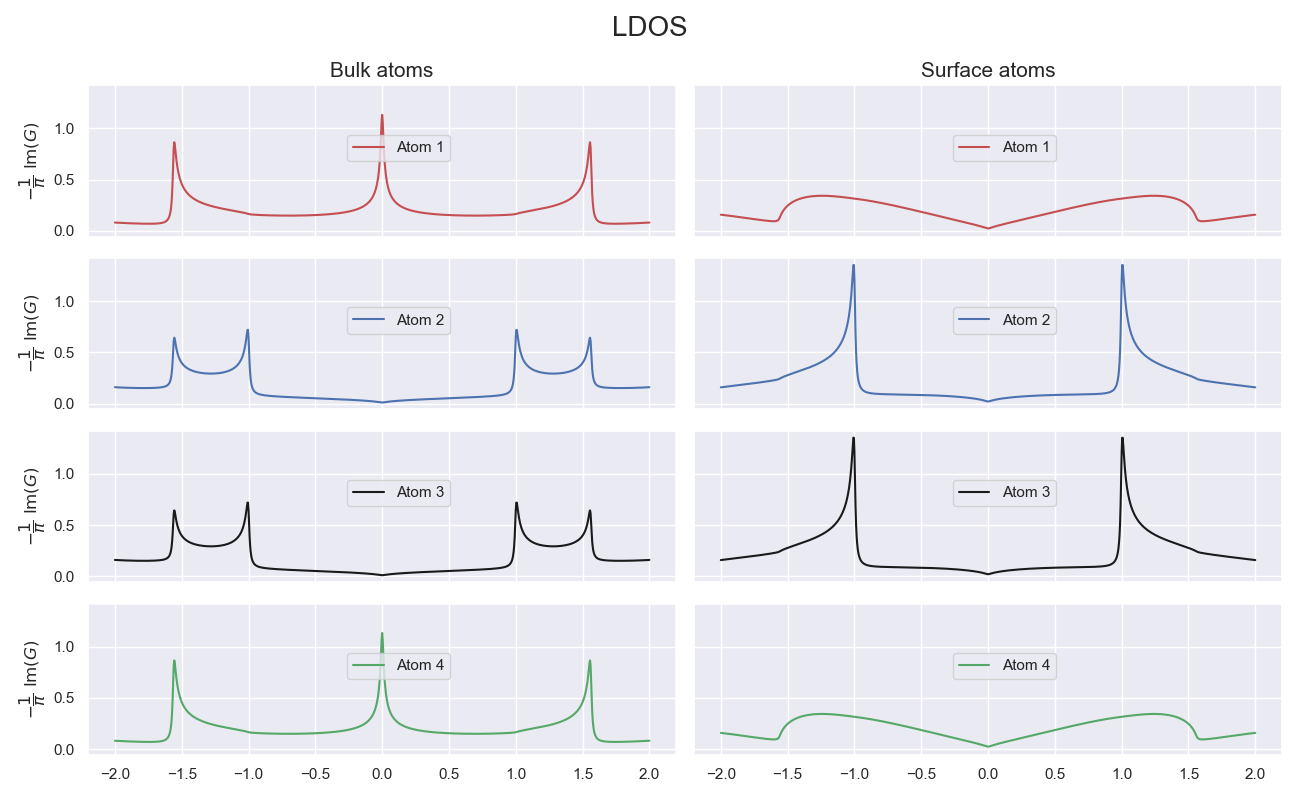

In [14]:
# Compute greens function for bulk and surface atoms
Greens_bulk, Greens_surf = Greens_broadcast(Energy, h=on_site, h_s=on_site, V=hopping, eta=1e-2)

# get the LDOS
LDOS_bulk = - np.imag(Greens_bulk) / np.pi
LDOS_surf = - np.imag(Greens_surf) / np.pi

# Initialize plot
fig, axis = plt.subplots(nrows=hopping.shape[-1], ncols=2, figsize=(13,8), sharex=True, sharey=True)
colors= ["r", "b", "k", "g"]

# plot each atom in a separeate graph
for idx in range(hopping.shape[-1]):
    axis[idx, 0].plot(Energy, LDOS_bulk[:, idx, idx], label=f"Atom {idx+1}", color=colors[idx])
    axis[idx, 1].plot(Energy, LDOS_surf[:, idx, idx], label=f"Atom {idx+1}", color=colors[idx])
    axis[idx, 0].legend(loc=(0.44,0.5))
    axis[idx, 1].legend(loc=(0.44,0.5))
    
    axis[idx, 0].set_ylabel(r"$ -\dfrac{1}{\pi}\ \mathrm{Im}(G)$")


axis[0, 0].set_title("Bulk atoms", fontsize=15)
axis[0, 1].set_title("Surface atoms", fontsize=15)

fig.suptitle("LDOS", fontsize=20)
fig.tight_layout()
plt.show()

## Using for-loop

In [15]:
# iterate arguments
def Iterate_greens(Energy, h, h_s, V, eta=1e-4, tol=1e-6, max_iter=50):
    # eta = 1e-3
    # tol = 1e-6
    g_surface_list = []
    g_bulk_list = []
    
    for E_idx, E in enumerate(Energy):
        
        beta = V.copy()
        
        alpha = V.copy().transpose()
        epsilon = h
        epsilon_s = h.copy()
        z = (E + 1.j * eta)* np.eye(len(epsilon))
        g_bulk = np.linalg.inv(z - epsilon)
        
        for idx in range(max_iter):
            # iterate parameters
            alpha_new = alpha @ g_bulk @ alpha
            beta_new = beta @ g_bulk @ beta
            
            right_self_energy = alpha @ g_bulk @ beta
            left_self_energy = beta @ g_bulk @ alpha
            
            epsilon_new = epsilon + right_self_energy + left_self_energy
            epsilon_s_new = epsilon_s + right_self_energy
            
            g_bulk = np.linalg.inv(z - epsilon_new)
            g_surface = np.linalg.inv(z - epsilon_s_new)
            
            # check that all matrix elements are converged
            if np.max(np.abs(alpha_new)) < tol:
                # print(f"Parameters converged after iterations: {idx+1}")
                break
            
            alpha = alpha_new.copy()
            beta = beta_new.copy()
            epsilon = epsilon_new.copy()
            epsilon_s = epsilon_s_new.copy()
            
            # Repeat until congerging
            
        # save result in list
        g_surface_list.append(g_surface)
        g_bulk_list.append(g_bulk)
        
    return np.array(g_bulk_list), np.array(g_surface_list)


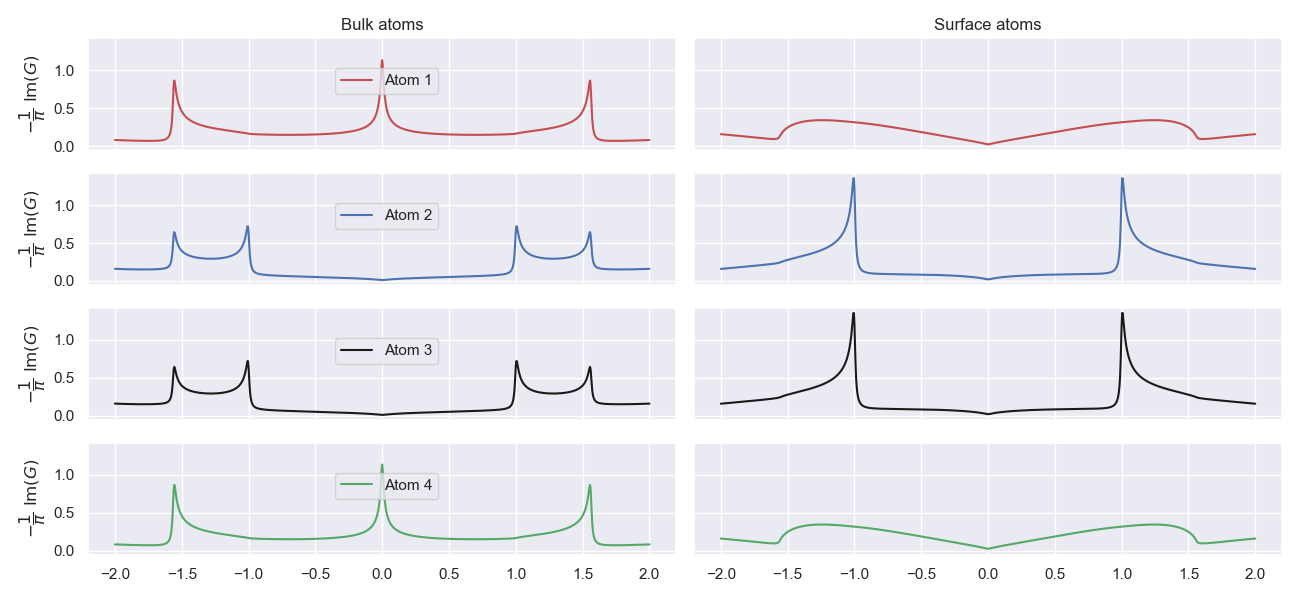

In [16]:
G_bulk, G_surf = Iterate_greens(Energy=Energy, h=on_site, h_s=on_site, V=hopping, eta=1e-2)

# Plotting
fig, axes = plt.subplots(4, 2, figsize=(13,6), sharex=True, sharey=True )
colors= ["r", "b", "k", "g"]
for i in range(4):
    # Plots diagonal of each matrix for each energy
    axes[i,0].plot(Energy, -1/np.pi*np.imag(G_bulk[:, i, i]),  label=f"Atom {i+1}", color=colors[i])
    axes[i,1].plot(Energy, -1/np.pi*np.imag(G_surf[:, i, i]), label=f"Atom {i+1}", color=colors[i])

for ax in axes[:,0].flatten():
    ax.set_ylabel(r"$ -\dfrac{1}{\pi}\ \mathrm{Im}(G)$")
    ax.legend(loc=(0.42,0.5))
axes[0,0].set_title("Bulk atoms")
axes[0,1].set_title("Surface atoms")
fig.tight_layout()

In [17]:
# initialize energy
E = np.linspace(-2, 2, num=1001)

hopping = np.array([[0,0,0,0],
                  [1,0,0,0],
                  [0,0,0,1],
                  [0,0,0,0]])
on_site = np.diag(np.ones(3), -1) + np.diag(np.ones(3), 1)

In [18]:
%timeit Iterate_greens(Energy=E, h=on_site, h_s=on_site, V=hopping, eta=1e-3, max_iter=50, tol=1e-6)

591 ms ± 47.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%timeit Greens_broadcast(Energy, h=on_site, h_s=on_site, V=hopping, eta=1e-3, max_iter=50, tol=1e-6)

61.3 ms ± 569 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
# test = np.array([[1]])
# bulk, surf = Greens_broadcast(Energy, h=test, h_s=test, V=0.5*test)
# fig, ax = plt.subplots()
# ax.plot(Energy, 1/np.pi*np.array([bulk.imag.squeeze(),surf.imag.squeeze()]).T)

![alt text](ex21-d.png)

See above